In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-01-20 07:11:30--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   102MB/s    in 1.9s    

2021-01-20 07:11:32 (102 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
!ls

ml-20m	ml-20m.zip  sample_data


In [6]:
df = pd.read_csv("ml-20m/ratings.csv")

In [7]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [9]:
df.userId = pd.Categorical(df.userId)

In [10]:
df["new_user_id"] = df.userId.cat.codes

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 5 columns):
 #   Column       Dtype   
---  ------       -----   
 0   userId       category
 1   movieId      int64   
 2   rating       float64 
 3   timestamp    int64   
 4   new_user_id  int32   
dtypes: category(1), float64(1), int32(1), int64(2)
memory usage: 616.4 MB


In [12]:
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes

In [13]:
user_ids = df.new_user_id.values
movie_ids = df.new_movie_id.values
ratings = df.rating.values

In [14]:
N = len(set(user_ids))
M = len(set(movie_ids))

K = 10

In [15]:
u = Input(shape=(1,))
m = Input(shape=(1,))

u_emb = Embedding(input_dim=N, output_dim=K)(u)
m_emb = Embedding(input_dim=M, output_dim=K)(m)

u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

x = Concatenate()([u_emb, m_emb])

x = Dense(units=1024, activation=tf.keras.activations.relu)(x)
x = Dense(units=400, activation=tf.keras.activations.relu)(x)
x = Dense(units=400, activation=tf.keras.activations.relu)(x)
x = Dense(units=1)(x)

model = Model(inputs=[u, m], outputs=[x])
model.compile(optimizer=SGD(lr=0.08, momentum=0.9), 
              loss=tf.keras.losses.mean_squared_error)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        1384930     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        267440      input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))

train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

avg_ratings = train_ratings.mean()
train_ratings = train_ratings - avg_ratings
test_ratings = test_ratings - avg_ratings

In [17]:
r = model.fit(x=[train_user, train_movie], 
              y=train_ratings, 
              epochs=25, 
              batch_size=1024, 
              validation_data=([test_user, test_movie], test_ratings), 
              verbose=2)

Epoch 1/25
15626/15626 - 63s - loss: 0.7827 - val_loss: 0.7264
Epoch 2/25
15626/15626 - 60s - loss: 0.7041 - val_loss: 0.6995
Epoch 3/25
15626/15626 - 60s - loss: 0.6828 - val_loss: 0.6900
Epoch 4/25
15626/15626 - 59s - loss: 0.6670 - val_loss: 0.6809
Epoch 5/25
15626/15626 - 59s - loss: 0.6558 - val_loss: 0.6742
Epoch 6/25
15626/15626 - 59s - loss: 0.6457 - val_loss: 0.6653
Epoch 7/25
15626/15626 - 59s - loss: 0.6345 - val_loss: 0.6610
Epoch 8/25
15626/15626 - 58s - loss: 0.6220 - val_loss: 0.6564
Epoch 9/25
15626/15626 - 58s - loss: 0.6078 - val_loss: 0.6458
Epoch 10/25
15626/15626 - 59s - loss: 0.5974 - val_loss: 0.6408
Epoch 11/25
15626/15626 - 59s - loss: 0.5887 - val_loss: 0.6391
Epoch 12/25
15626/15626 - 58s - loss: 0.5804 - val_loss: 0.6383
Epoch 13/25
15626/15626 - 59s - loss: 0.5724 - val_loss: 0.6354
Epoch 14/25
15626/15626 - 59s - loss: 0.5649 - val_loss: 0.6340
Epoch 15/25
15626/15626 - 59s - loss: 0.5585 - val_loss: 0.6337
Epoch 16/25
15626/15626 - 59s - loss: 0.5528 - va

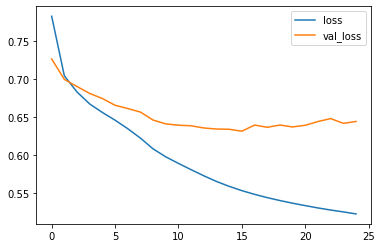

In [18]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()